In [1]:
import qutip as qt
import numpy as np

# Tracking info of simulations
import tqdm
import time
import warnings

#Saving data
import pandas as pd
import json
import os

import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec

In [2]:
from model_building import initialize_1_qubit_system, crate_domain_wall_state, initialize_general_system
from Hamiltonian import Hamiltonian, domain_wall_J
import dynamics as dyn
import data_handling as dh


In [3]:
# Generate standard encoding state
N = 10
alpha = 1
beta = 1

psi0 = initialize_1_qubit_system(N, alpha, beta, register = "Alice")
psi_target = initialize_1_qubit_system(N, alpha, beta, register = "Bob")

In [4]:
#generate domain wall state and domain wall chain
dictionary = {"001":0.4,"101":0.2,"111":0.6,"110":0.35}
dictionary = {"1":1, "0":1}
dictionary = {"001":1}
initial_state = crate_domain_wall_state(dictionary, register='Alice')
final_state = crate_domain_wall_state(dictionary, register='Bob')

initial_chain = initialize_general_system(N, initial_state, register='Alice')
final_chain = initialize_general_system(N, final_state, register='Bob')

In [5]:
#test Hamiltonian building
l = 0.02272
J = 0.5
reg_N = len(initial_state.dims[0])
reg_size = len(initial_state.dims[0])

standard_H = Hamiltonian(system_size = N,
                         mode = "standard",
                         lambda_factor = l
                         )

forward_H = Hamiltonian(system_size = N,
                         mode = "forward",
                         lambda_factor = l,
                         global_J = J
                         )

backward_H = Hamiltonian(system_size = N,
                         mode = "backward",
                         lambda_factor = l,
                         register_size = reg_size,
                         global_J = J
                         )

In [6]:
#test operations
H = standard_H
ti = 0
tf = 150
Nstep = 500
result_s = dyn.time_evolution(H, psi0, ti, tf, Nstep)
full_fidelity_s = dyn.calculate_full_fidelity(result_s, psi_target)
magnetizations_s = dyn.calculate_z_expectation_values(result_s, H.sz_list)

c:\Users\User\anaconda3\envs\TFM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 499/499 [00:00<00:00, 15810.46it/s]


In [14]:
# Test DW operations
H_f = forward_H
H_b = backward_H

ti = 0
tf = 138
Nstep = 460
result_f = dyn.time_evolution(H_f, initial_chain, ti, tf, Nstep)
full_fidelity_f = dyn.calculate_full_fidelity(result_f, final_chain)
magnetizations_f = dyn.calculate_z_expectation_values(result_f, H_f.sz_list)


result_b = dyn.time_evolution(H_b, result_f.states[-1] , ti, tf*1.12, int(Nstep*1.12))
full_fidelity_b = dyn.calculate_full_fidelity(result_b, final_chain)
magnetizations_b = dyn.calculate_z_expectation_values(result_b, H_b.sz_list)

total_full_fidelity = np.concatenate((full_fidelity_f, full_fidelity_b), axis=0)
magnetizations = np.concatenate((magnetizations_f, magnetizations_b), axis=0)

100%|██████████| 514/514 [00:00<00:00, 2040.35it/s]


In [8]:
print(domain_wall_J(H_f.n_spins -1, H_f.lambda_factor))

[0.03408    0.04544    0.05205806 0.05565241 0.0568     0.05565241
 0.05205806 0.04544    0.03408   ]


In [27]:
# data storage test
f_filename = dh.create_data_filename(N, J, l, dictionary, base_name="fidelity", extension = "npy")
z_filename = dh.create_data_filename(N, J, l, dictionary, base_name="z_expectation", extension = "npy")


print(z_filename)

z_expectation_N10_J0.5_L0.023_001_1_20250916_115842.npy


In [ ]:
dh.save_numpy_array(total_full_fidelity, f'data_files/fidelity/{f_filename}')
dh.save_numpy_array(magnetizations, f'data_files/z_expectation/{z_filename}')

In [ ]:
#data read test

fetched_fidelity = 

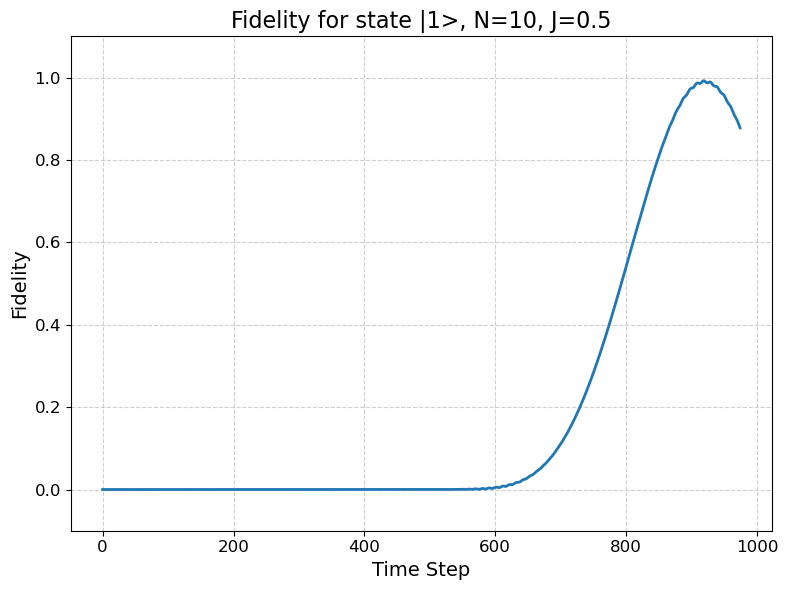

0.9921542258800647
919


In [13]:
total_full_fidelity = np.concatenate((full_fidelity_f, full_fidelity_b), axis=0)
#total_full_fidelity = full_fidelity_s

#total_full_fidelity = np.concatenate((tfc, tfb), axis=0) 
#total_full_fidelity = np.concatenate((dff, dfb), axis=0)
plt.figure(figsize=(8, 6))
# Plot each curve
num_steps = len(total_full_fidelity)
plt.plot(range(num_steps), total_full_fidelity, label=f'Fidelity', linestyle='-', linewidth=2)

# Add labels, title, legend, and grid
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
# plt.title('<Z> for N=7, J=-5, α = 1', fontsize=16)
# plt.title('Fidelity for N=7, J=5, α = 0.8', fontsize=16)
plt.title(f'Fidelity for state |1>, N={N}, J={J}', fontsize=16)
# plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

print(max(total_full_fidelity))
print(np.argmax(total_full_fidelity))

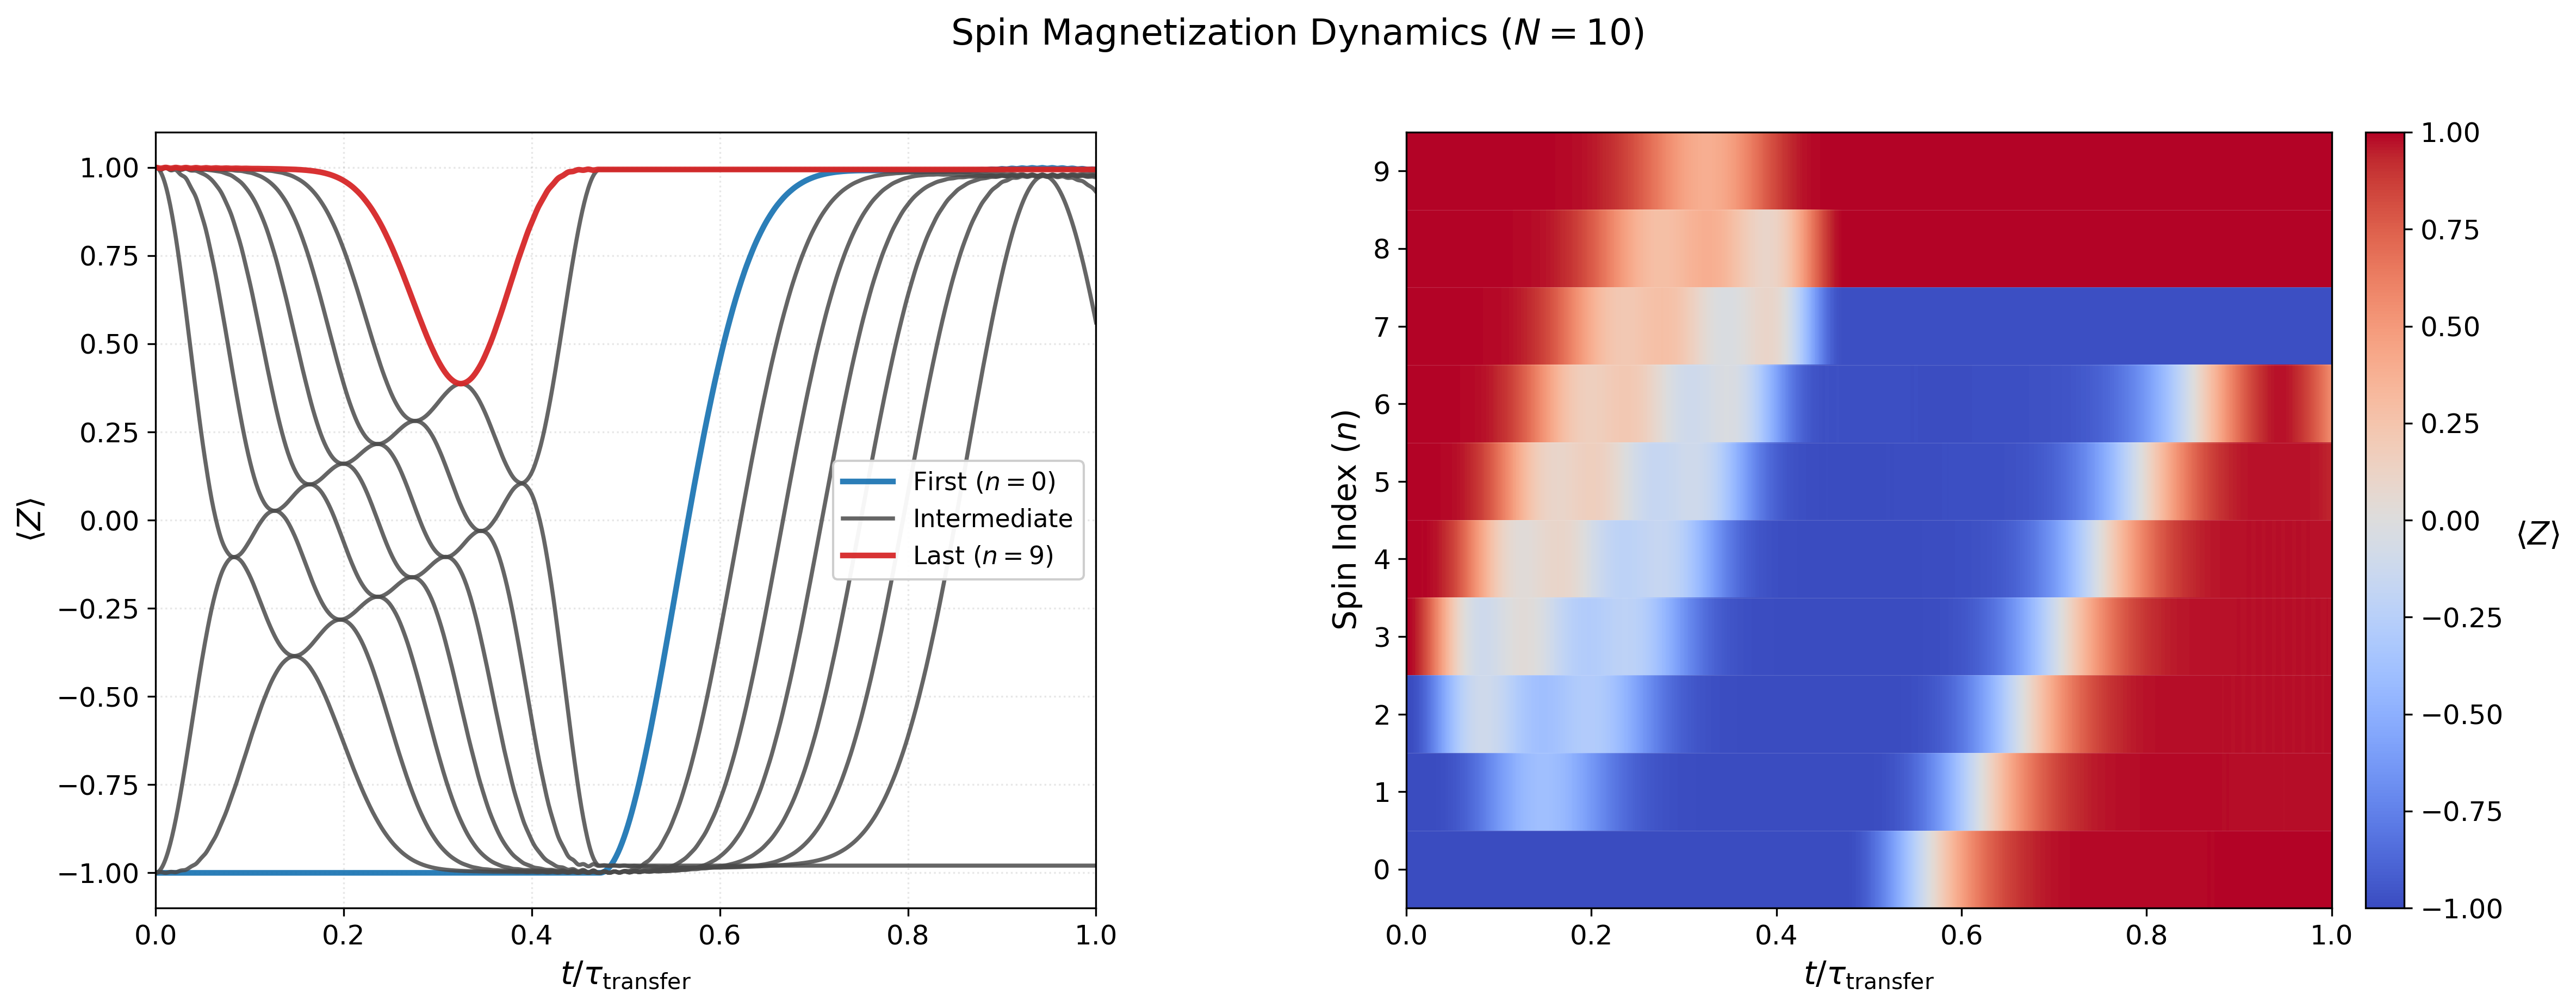

In [11]:
magnetizations = np.concatenate((magnetizations_f, magnetizations_b), axis=0)
# Create figure with side-by-side subplots
fig = plt.figure(figsize=(16, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[1, 1.2])  # Heatmap slightly wider

# Custom colors
first_color = '#1f77b4'  # Blue
last_color = '#d62728'   # Red
middle_color = '#4a4a4a' # Dark gray

# ========== LEFT PANEL: LINE PLOT ==========
ax1 = fig.add_subplot(gs[0])

for i in range(N):
    magn = magnetizations[:,i]
    norm_time = np.linspace(0, 1, len(magn))
    
    lineprops = {
        'color': first_color if i == 0 else (last_color if i == N-1 else middle_color),
        'lw': 2.5 if i in [0, N-1] else 1.8,
        'alpha': 0.95 if i in [0, N-1] else 0.85,
        'label': r'First $(n=0)$' if i == 0 else (r'Last $(n={})$'.format(N-1) if i == N-1 else "")
    }
    if i == 1 and N > 2:
        lineprops['label'] = 'Intermediate'
    
    ax1.plot(norm_time, magn, **lineprops)

# Formatting
ax1.set_xlabel(r'$t/\tau_{\mathrm{transfer}}$', fontsize=14)
ax1.set_ylabel(r'$\langle Z \rangle$', fontsize=14)
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlim(0, 1)
ax1.tick_params(labelsize=12)
ax1.grid(True, linestyle=':', alpha=0.3)

# Simplified legend
handles, labels = ax1.get_legend_handles_labels()
if N > 2:
    # Only show first, last, and one intermediate
    handles = [handles[0], handles[1], handles[-1]] if N > 2 else handles
    labels = [labels[0], 'Intermediate', labels[-1]] if N > 2 else labels
ax1.legend(handles, labels, fontsize=11, framealpha=0.95)

# ========== RIGHT PANEL: HEATMAP ==========
ax2 = fig.add_subplot(gs[1])

# Heatmap with improved display
heatmap = ax2.imshow(
    magnetizations.T,
    aspect='auto',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    extent=(0, 1, 0, N),
    origin='lower',
    interpolation='none'  # Sharp color boundaries
)

# Colorbar with matching style
cbar = fig.colorbar(heatmap, ax=ax2, pad=0.03)
cbar.set_label(r'$\langle Z \rangle$', fontsize=14, rotation=0, labelpad=15)
cbar.ax.tick_params(labelsize=12)

# Clean axis formatting
ax2.set_xlabel(r'$t/\tau_{\mathrm{transfer}}$', fontsize=14)
ax2.set_ylabel('Spin Index ($n$)', fontsize=14)
ax2.set_yticks(np.arange(0.5, N+0.5, 1))
ax2.set_yticklabels(np.arange(N))
ax2.tick_params(labelsize=12)

# Subtle horizontal guides (reduced visibility)
for n in range(1, N):
    ax2.axhline(n, color='white', lw=0.3, alpha=0.15)

# ========== GLOBAL FORMATTING ==========
plt.suptitle(r'Spin Magnetization Dynamics ($N={}$)'.format(N), 
             fontsize=16, y=1.02)

# Final layout adjustment
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Horizontal spacing

# Save
# plt.savefig('figures/good_figures/side_by_side_spin_dynamics.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
# Test if these are the same
def test_coupling_functions():
    size = 5
    factor = 1.0
    
    def domain_wall_J(size, factor):
        strengths = np.zeros(size)
        for i in range(0,size):
            strengths[i] = 0.5*factor*np.sqrt((i+1)*(size-i))
        return strengths
    
    def J_definition(size, factor):
        strengths = np.zeros(size)
        for i in range(0,size):
            strengths[i] = 0.5*factor*np.sqrt((i+1)*(size-i))
        return strengths
    
    result1 = domain_wall_J(size, factor)
    result2 = J_definition(size, factor)
    
    print("domain_wall_J:", result1)
    print("J_definition:", result2)
    print("Are they equal?", np.allclose(result1, result2))

test_coupling_functions()

domain_wall_J: [1.11803399 1.41421356 1.5        1.41421356 1.11803399]
J_definition: [1.11803399 1.41421356 1.5        1.41421356 1.11803399]
Are they equal? True
